<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/VGG_SBDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras,os
import cv2
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model,load_model
from keras import layers
from keras import regularizers
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.layers import Concatenate

In [2]:
!unzip -qq images.zip

In [3]:
!unzip -qq labels.zip

In [4]:
from numpy import *
images_folder= "images/*.jpg"
labels_folder = "labels/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  class_label=[]
  label = []
  files = glob.glob (images_folder)
  for myFile in files[:6000]:
      image_name=os.path.split(myFile)[1]
      class_label.append(float(image_name[0]))
      image = array(Image.open(myFile))
      label_image = array(Image.open(labels_folder+image_name))
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  class_label=np.array(class_label) 
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2],label.shape[3]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  #np.save('class_labels', class_label)
  #np.save('total-images',total_img)
  #np.save('label-images',label)
  return class_label,label,total_img

In [5]:
class_labels,total_labels,total_images=data_preprocessing(images_folder,labels_folder)

In [6]:
total_images.shape

(6000, 224, 224, 3)

In [7]:
def identifier(x,name=None):
  layer = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same',activation="relu")(x)
  layer = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same',activation="relu")(layer)
  layer = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same',activation="relu")(layer)
  layer = layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same',activation="relu")(layer)
  layer = layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same',activation="relu")(layer)
  layer = layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same',activation="sigmoid")(layer)
  layer = layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same',activation="sigmoid", name=name)(layer)
  return layer

In [8]:
def vggnet():
    layer_in = Input(shape=(224, 224, 3))
    layer = layers.Conv2D(64,(3,3),padding="same", activation="relu")(layer_in)
    layer =layers.Conv2D(64,(3,3),padding="same", activation="relu")(layer)
    layer = layers.MaxPool2D((2,2),strides=(2,2))(layer)
    layer = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(layer)
    layer = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(layer)
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(layer)
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(layer)
    layer = layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(layer)
    ident  = identifier(layer, name='ident')
    layer = layers.Flatten()(layer)
    layer = layers.Dense(units=4096,activation="relu")(layer)
    layer = layers.Dense(units=4096,activation="relu")(layer)
    main = layers.Dense(units=1, activation="sigmoid",name="main")(layer)
    model = Model(inputs=layer_in, outputs=[main,ident])
    return model

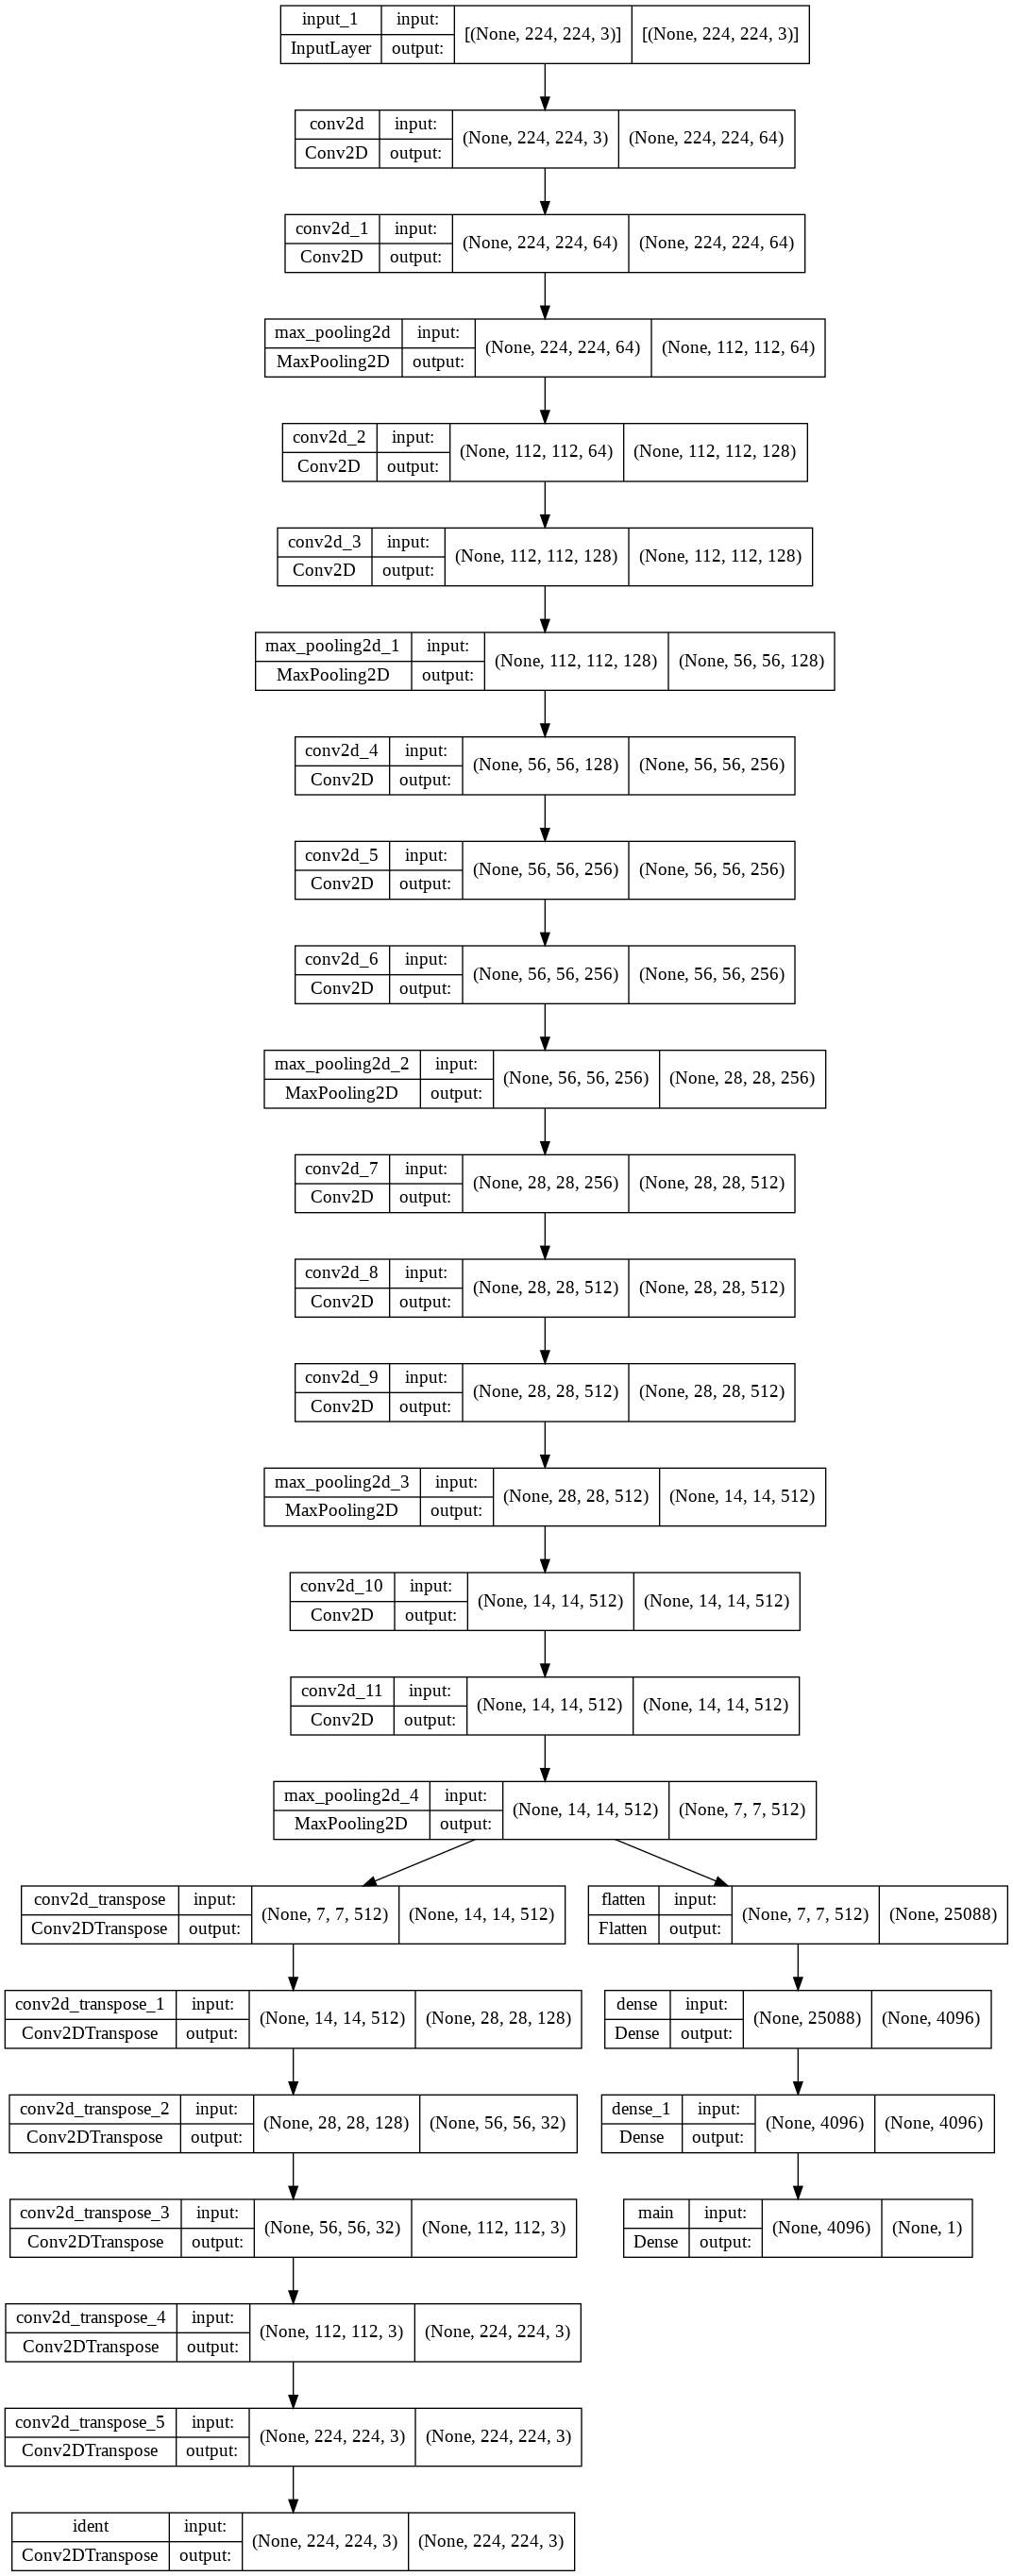

In [9]:
model=vggnet()
keras.utils.plot_model(model, show_shapes=True)

In [10]:
loss1="binary_crossentropy"
loss2=tf.keras.losses.MeanSquaredError()
model.compile(keras.optimizers.Adam(learning_rate=1e-3),loss = [loss1,loss2],metrics=["accuracy"])

In [11]:
class_label=class_labels[:5000]
x_train = total_images[:5000].astype(np.float32)/ 255.0
y_train=total_labels[:5000].astype(np.float32)/ 255.0
y_train =(y_train,class_label)

In [13]:
history = model.fit(x_train,[y_train[1],y_train[0]], epochs=5,batch_size=20, validation_split=0.2,shuffle=True)
model.save('vggnet_model.h5')

Epoch 1/5
200/200 [==============================] - 41s 203ms/step - loss: 0.7721 - main_loss: 0.6931 - ident_loss: 0.0790 - main_accuracy: 0.5065 - ident_accuracy: 0.3128 - val_loss: 0.7718 - val_main_loss: 0.6930 - val_ident_loss: 0.0788 - val_main_accuracy: 0.5080 - val_ident_accuracy: 0.9871
Epoch 2/5
200/200 [==============================] - 41s 203ms/step - loss: 0.7721 - main_loss: 0.6931 - ident_loss: 0.0790 - main_accuracy: 0.5065 - ident_accuracy: 0.3381 - val_loss: 0.7718 - val_main_loss: 0.6930 - val_ident_loss: 0.0788 - val_main_accuracy: 0.5080 - val_ident_accuracy: 0.0089
Epoch 3/5
200/200 [==============================] - 41s 204ms/step - loss: 0.7721 - main_loss: 0.6931 - ident_loss: 0.0790 - main_accuracy: 0.5065 - ident_accuracy: 0.1808 - val_loss: 0.7718 - val_main_loss: 0.6930 - val_ident_loss: 0.0788 - val_main_accuracy: 0.5080 - val_ident_accuracy: 0.0091
Epoch 4/5
200/200 [==============================] - 41s 203ms/step - loss: 0.7721 - main_loss: 0.6931 - i

In [14]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'main_loss', 'ident_loss', 'main_accuracy', 'ident_accuracy', 'val_loss', 'val_main_loss', 'val_ident_loss', 'val_main_accuracy', 'val_ident_accuracy'])


In [22]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'vgghistory.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

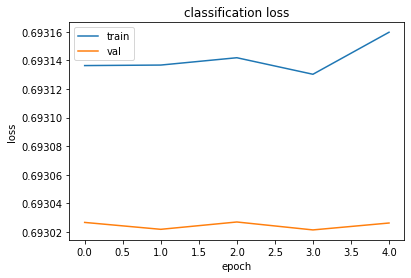

In [16]:
plt.plot(history.history['main_loss'])
plt.plot(history.history['val_main_loss'])
plt.title('classification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

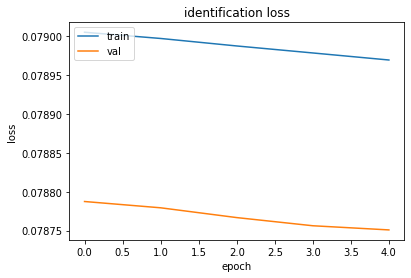

In [17]:
plt.plot(history.history['ident_loss'])
plt.plot(history.history['val_ident_loss'])
plt.title('identification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

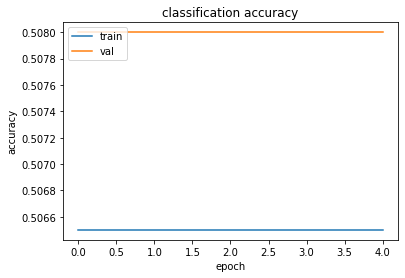

In [18]:
plt.plot(history.history['main_accuracy'])
plt.plot(history.history['val_main_accuracy'])
plt.title('classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

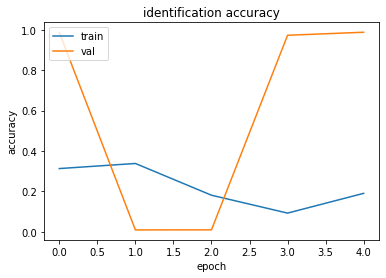

In [19]:
plt.plot(history.history['ident_accuracy'])
plt.plot(history.history['val_ident_accuracy'])
plt.title('identification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
eval_images=total_images[5000:]
eval_labels=total_labels[5000:]
eval_class_label=class_labels[5000:]

In [21]:
from keras.models import load_model
from PIL import Image
images = eval_images
model = load_model("vggnet_model.h5")
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [25]:
predictions[0][0]

array([[0.49386913]], dtype=float32)

In [26]:
y_pred_class=[]
for i in range(len(predictions)):
  predicted_class=((predictions[i])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  y_pred_class.append(predicted_class)
y_pred_class=np.array(y_pred_class)

Confusion Matrix

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
conf_m = confusion_matrix(eval_class_label, y_pred_class)
conf_m

array([[537,   0],
       [463,   0]])

In [28]:
report = classification_report(eval_class_label, y_pred_class)
print(report)

              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70       537
         1.0       0.00      0.00      0.00       463

    accuracy                           0.54      1000
   macro avg       0.27      0.50      0.35      1000
weighted avg       0.29      0.54      0.38      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
def get_iou_score(predictions,eval_labels):
  iou_scores=[]
  for i in range(len(predictions)):
    true_label = eval_labels[i]/255.0
    y_pred_label = np.where((((predictions[i])[1])[0])>0.5,1.0,0.0)
    #y_pred_label= ((((predictions[i])[0])[0])*255.0).astype(np.uint8)
    #iou = true_positives / (true_positives + false_positives + false_negatives)
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(true_label, y_pred_label)
    iou_scores.append(m.result().numpy())
    #intersection = np.logical_and(true_label, y_pred_label)
    #union = np.logical_or(true_label, y_pred_label)
    #iou_score = np.sum(intersection) / np.sum(union)
    #iou_scores.append(iou_score)
  return mean(iou_scores)

In [30]:
iou_score = get_iou_score(predictions,eval_labels)

In [31]:
print('Average Intersection over Union IoU for Blur Detection: ',iou_score )

Average Intersection over Union IoU for Blur Detection:  0.6895486


predicted class vs true class


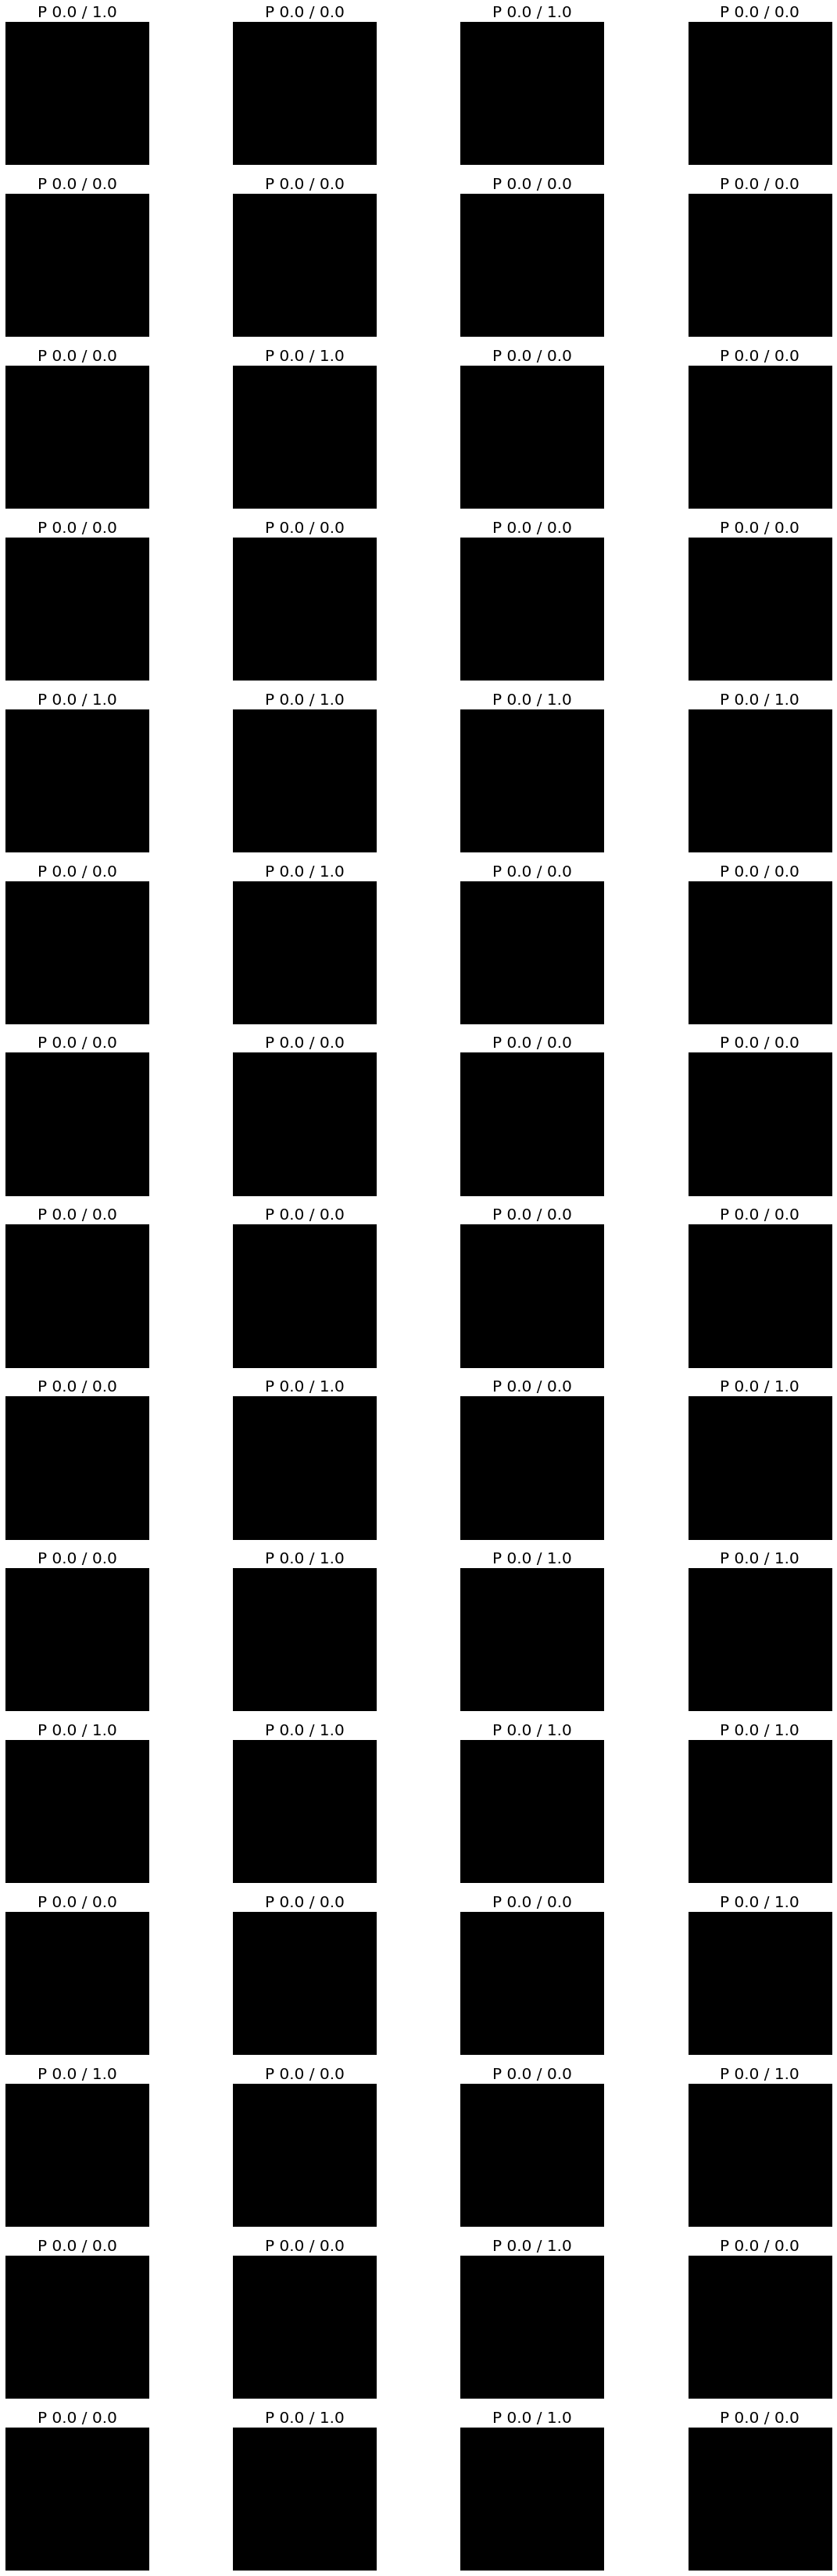

In [32]:
columns = 4
rows = 15
print("predicted class vs true class")
fig = plt.figure(figsize=(20,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[1])[0])>0.5,1.0,0.0)
  plt.imshow((img_pred_label*255.0).astype(np.uint8))
  predicted_class=(((predictions[i])[0])[0])
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=20)
  plt.axis("off")
plt.show()

predicted class vs true class


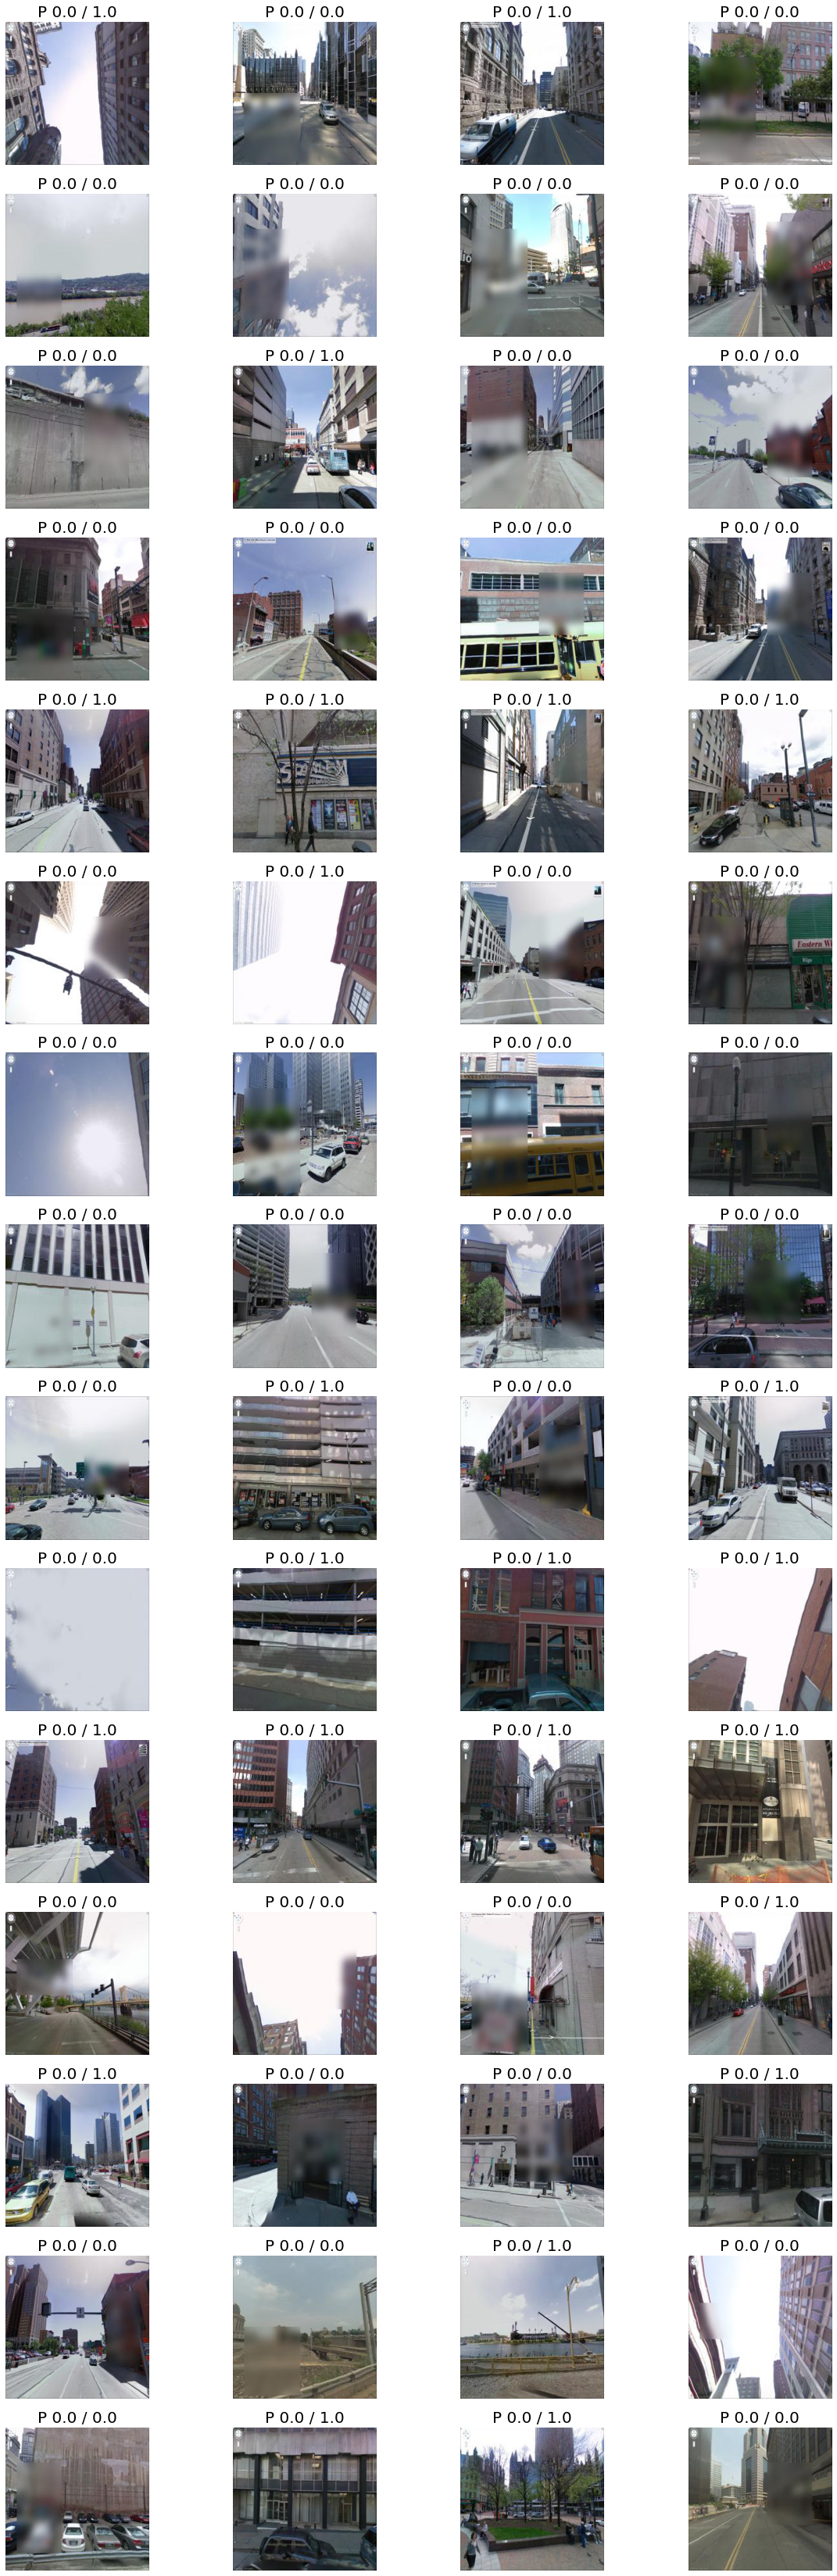

In [33]:
fig = plt.figure(figsize=(20,60))
columns = 4
rows = 15
print("predicted class vs true class")
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[1])[0])>0.5,1.0,0.0)
  mask=(img_pred_label*255.0).astype(np.uint8)
  blackFrame = np.zeros((224,224, 3), dtype = "uint8")
  whiteFrame = 255 * np.ones((224,224,3), np.uint8)
  #label_img = Image.fromarray(label_img)
  mask = np.where(mask==255,whiteFrame,blackFrame)
  img= images[i]
  cyan = np.full_like(img,(80, 229, 235))
  blend = 0.5
  img_cyan = cv2.addWeighted(img, blend, cyan, 1-blend, 0)
  mask = np.where(mask>=165,img_cyan,img)
  #mask =cv2.cvtColor(mask , cv2.COLOR_BGR2RGB)
  plt.imshow(mask,cmap='binary')
  #mask = Image.fromarray(mask)
  predicted_class=(((predictions[i])[0])[0])
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=20)
  plt.axis("off")
plt.show()